In [96]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from scipy.io import loadmat
from sklearn.model_selection import StratifiedKFold
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model
from scipy.optimize import minimize
from keras import regularizers

In [97]:
dataTT = loadmat(f"Data04-08_TT_UltVag_Cut.mat")
dataVG = loadmat(f"Data04-08_TF_UltVag_Cut.mat")

dataBaseline = dataVG['Baseline']
dataCincoP = dataVG['CincoP']
dataDez = dataVG['DezP']
dataVinte = dataVG['VinteP']

X_test = pd.DataFrame()

X_train = pd.DataFrame(dataBaseline)

dataBaseline_df = pd.DataFrame(dataBaseline)


dataCincoP_df = pd.DataFrame(dataCincoP)
X_test = pd.concat([X_test, dataCincoP_df], ignore_index=True)

dataDez_df = pd.DataFrame(dataDez)
X_test = pd.concat([X_test, dataDez_df], ignore_index=True)

dataVinte_df = pd.DataFrame(dataVinte)
X_test = pd.concat([X_test, dataVinte_df], ignore_index=True)

X_train = X_train.fillna(0)

X_train_test = X_train.sample(n=200, random_state=42)

X_train = X_train.drop(X_train_test.index)

X_train.reset_index(drop=True, inplace=True)

X_test = X_test.fillna(0)

In [98]:
encoding_dim = 32
num_terms = X_train.columns.shape[0]
input_layer = Input(shape=(num_terms,))
encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(num_terms, activation='linear')(decoded)

autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_train_test, X_train_test))

Epoch 1/100
4/4 [==============================] - 1s 59ms/step - loss: 0.0508 - val_loss: 0.0310
Epoch 2/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0233 - val_loss: 0.0230
Epoch 3/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0196 - val_loss: 0.0162
Epoch 4/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0164 - val_loss: 0.0115
Epoch 5/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0113 - val_loss: 0.0109
Epoch 6/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0096 - val_loss: 0.0075
Epoch 7/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0071 - val_loss: 0.0061
Epoch 8/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 9/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 10/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 11/100
4/4 [=

94/94 [==============================] - 0s 2ms/step


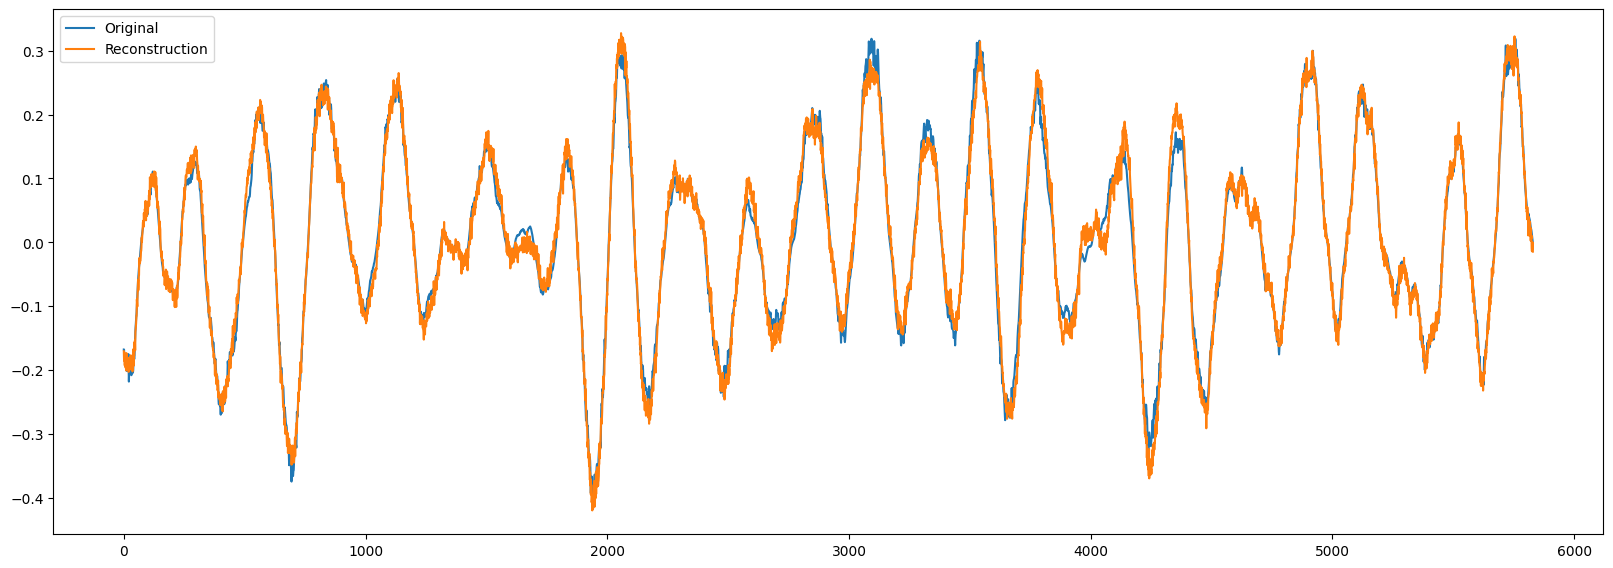

In [99]:
n = 1
x = np.arange(0, num_terms)
decoded_results = autoencoder.predict(X_test)
plt.figure(figsize=(20, 15))

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.plot(x, X_test.iloc[i].values, label="Original")

    # Display reconstruction
    plt.plot(x, decoded_results[i], label="Reconstruction")

plt.legend()
plt.show()


Mahalanobis mae médio :  0.0


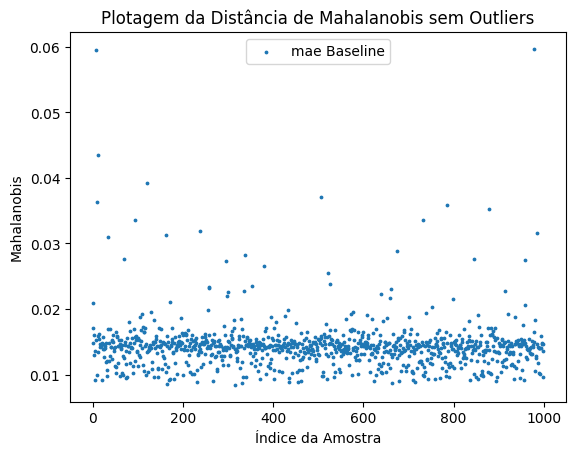

Mahalanobis mae médio :  0.015751302921395833


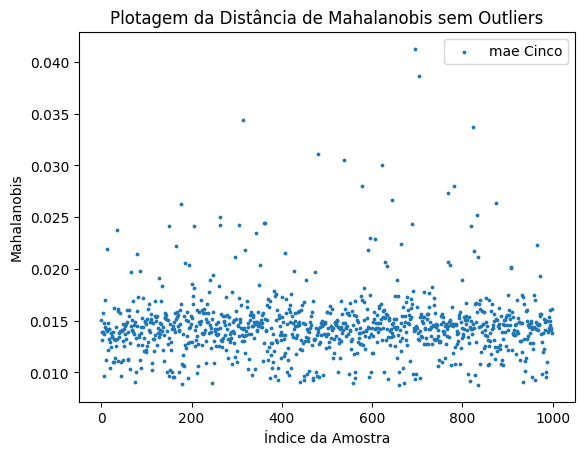

Mahalanobis mae médio :  0.051091837783102


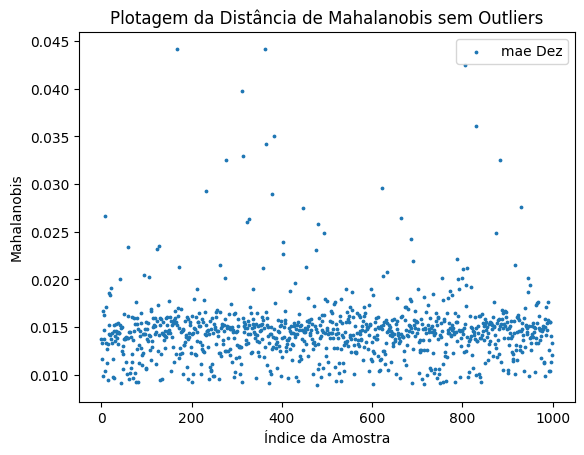

Mahalanobis mae médio :  0.5105471897971591


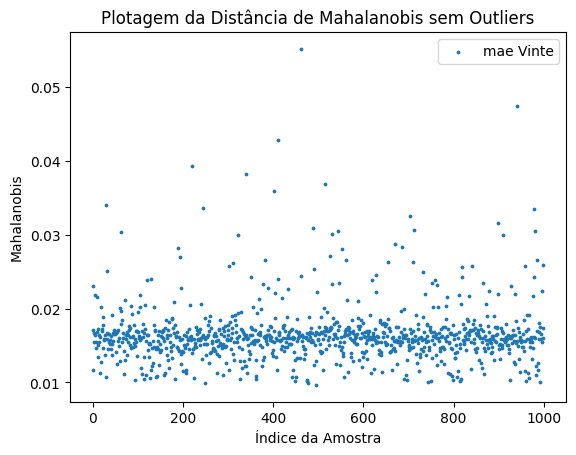

In [100]:
mae_Baseline = []  # Inicializar como uma lista

for i in range(dataBaseline_df.shape[0]):
    y = np.array(dataBaseline_df.iloc[i])
    y_predict = autoencoder.predict(dataBaseline_df.iloc[i].values.reshape(1, -1), verbose=0)
    y_predict = y_predict[0]
    mae_Atual = np.mean(np.abs((y_predict - y)))  # Calculando o mae atual e usando np.mean()
    mae_Baseline.append(mae_Atual)

mae_Baseline = np.array(mae_Baseline)

def mae_Dano(dadoAnalisado, autoencoder, mae_Baseline, label):
    mae_Medio = np.array([])

    for i in range(dadoAnalisado.shape[0]):
        y = np.array(dadoAnalisado.iloc[i])
        y_predict = autoencoder.predict(dadoAnalisado.iloc[i].values.reshape(1, -1), verbose=0)
        y_predict = y_predict[0]
        mae_Atual = np.mean(np.abs((y_predict - y)))  # Calculando o mae atual e usando np.mean()
        mae_Medio = np.append(mae_Medio, mae_Atual)

    mahalanobis = np.sqrt(((mae_Medio.mean() - mae_Baseline.mean()) ** 2) / (mae_Baseline.std()) ** 2)
   
    print(f"Mahalanobis mae médio : ", mahalanobis)
    x = np.arange(0,mae_Medio.shape[0])
    plt.scatter(x, mae_Medio, s = 3)
    plt.xlabel('Índice da Amostra')
    plt.ylabel('Mahalanobis')
    plt.title('Plotagem da Distância de Mahalanobis sem Outliers')
    plt.gca().legend((label,))
    plt.show()

    return mahalanobis, mae_Baseline, mae_Medio

# Chamar a função para cada cenário com a etiqueta apropriada
mae_baseline = mae_Dano(dataBaseline_df, autoencoder, mae_Baseline, 'mae Baseline')
mae_Cinco = mae_Dano(dataCincoP_df, autoencoder, mae_Baseline, 'mae Cinco')
mae_Dez = mae_Dano(dataDez_df, autoencoder, mae_Baseline, 'mae Dez')
mae_Vinte = mae_Dano(dataVinte_df, autoencoder, mae_Baseline, 'mae Vinte')


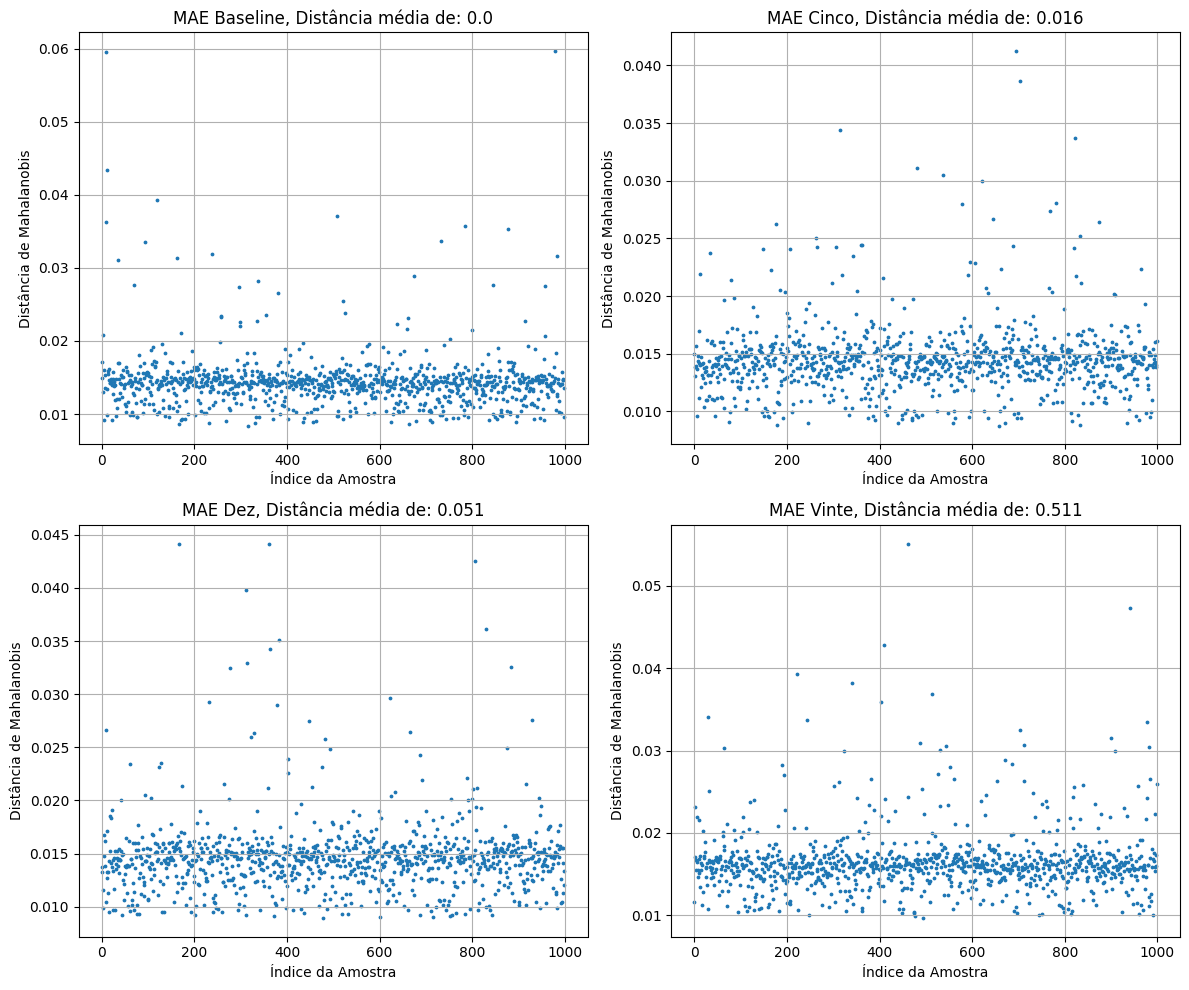

In [105]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Chamar a função para cada cenário com a etiqueta apropriada e plotar em um grid
for i, (mae_data, label) in enumerate([(mae_baseline, 'MAE Baseline'), (mae_Cinco, 'MAE Cinco'), (mae_Dez, 'MAE Dez'), (mae_Vinte, 'MAE Vinte')]):
    ax = axs[i // 2, i % 2]
    x = np.arange(0, mae_data[2].shape[0])
    ax.scatter(x, mae_data[2], s=3)
    ax.set_xlabel('Índice da Amostra')
    ax.set_ylabel('Distância de Mahalanobis')
    ax.set_title(f'{label}, Distância média de: {np.round(mae_data[0],3)}')
    ax.grid(True)

plt.tight_layout()
plt.show()

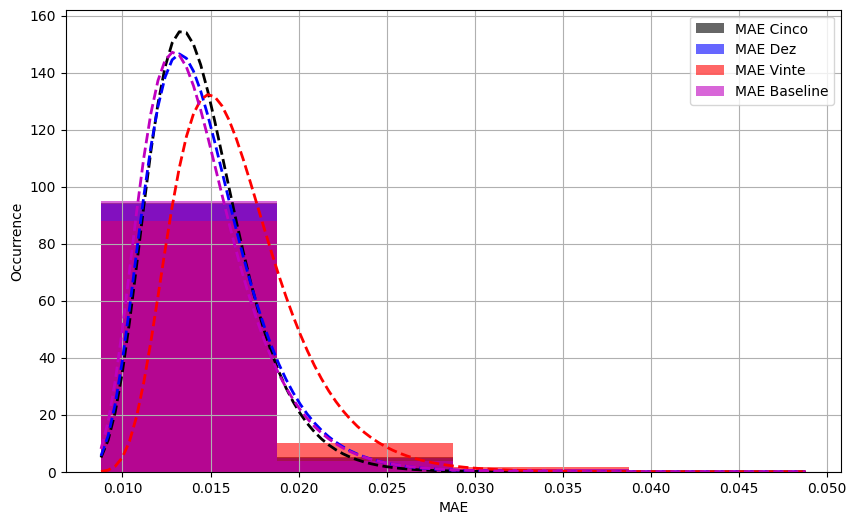

In [106]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import lognorm

bin_width = 0.01
bins = np.arange(min(mae_Cinco[2]), max(mae_Cinco[2]) + bin_width, bin_width)

# Plotando o histograma para mae_Cinco
plt.figure(figsize=(10,6))
plt.hist(mae_Cinco[2], bins=bins, density=True, alpha=0.6, color='black', label='MAE Cinco')  # Cor corrigida para verde

# Ajustando uma curva de distribuição lognormal aos dados de mae_Cinco
shape, loc, scale = lognorm.fit(mae_Cinco[2])
x = np.linspace(min(bins), max(bins), 100)
pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'k--', linewidth=2)

# Plotando o histograma para mae_Dez
plt.hist(mae_Dez[2], bins=bins, density=True, alpha=0.6, color='b', label='MAE Dez')

# Ajustando uma curva de distribuição lognormal aos dados de mae_Dez
shape, loc, scale = lognorm.fit(mae_Dez[2])
pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'b--', linewidth=2)

# Plotando o histograma para mae_Vinte
plt.hist(mae_Vinte[2], bins=bins, density=True, alpha=0.6, color='r', label='MAE Vinte')

# Ajustando uma curva de distribuição lognormal aos dados de mae_Vinte
shape, loc, scale = lognorm.fit(mae_Vinte[2])
pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'r--', linewidth=2)

# Plotando o histograma para mae_Baseline
plt.hist(mae_baseline[2], bins=bins, density=True, alpha=0.6, color='m', label='MAE Baseline')

# Ajustando uma curva de distribuição lognormal aos dados de mae_Baseline
shape, loc, scale = lognorm.fit(mae_baseline[2])
pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'm--', linewidth=2)

plt.xlabel('MAE')
plt.ylabel('Occurrence')
plt.legend()
plt.grid(True)
plt.show()
